<a href="https://colab.research.google.com/github/fourmodern/toc_tutorial_colab/blob/main/teachopencadd/t043_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 46.5 MB/s eta 0:00:00


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
import ast
import requests
import os
from pathlib import Path

RDLogger.DisableLog("rdApp.*")

# 상수 정의
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)

SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 100
EPOCHS = 10
NUM_ATOMS = 120
ATOM_DIM = len(SMILE_CHARSET)
BOND_DIM = 4 + 1
LATENT_DIM = 435

def download_file(url, filename):
    """파일 다운로드 함수"""
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        return True
    return False

# 데이터 파일 경로 설정
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)
csv_path = data_dir / '250k_rndm_zinc_drugs_clean_3.csv'

# 데이터 다운로드 (파일이 없는 경우에만)
if not csv_path.exists():
    url = "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"
    print("데이터 다운로드 중...")
    success = download_file(url, csv_path)
    if success:
        print(f"데이터가 성공적으로 다운로드되었습니다: {csv_path}")
    else:
        raise Exception("데이터 다운로드 실패")

In [3]:
def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

class MoleculeDataset(Dataset):
    def __init__(self, df, num_samples=8000):
        self.adjacency_tensor = []
        self.feature_tensor = []
        self.qed_tensor = []

        # 데이터 수집
        for idx in range(min(num_samples, len(df))):
            adjacency, features = smiles_to_graph(df.loc[idx]["smiles"])
            qed = df.loc[idx]["qed"]
            self.adjacency_tensor.append(adjacency)
            self.feature_tensor.append(features)
            self.qed_tensor.append(qed)

        # numpy 배열로 먼저 변환
        self.adjacency_tensor = np.array(self.adjacency_tensor, dtype=np.float32)
        self.feature_tensor = np.array(self.feature_tensor, dtype=np.float32)
        self.qed_tensor = np.array(self.qed_tensor, dtype=np.float32)

        # numpy 배열을 torch 텐서로 변환
        self.adjacency_tensor = torch.from_numpy(self.adjacency_tensor)
        self.feature_tensor = torch.from_numpy(self.feature_tensor)
        self.qed_tensor = torch.from_numpy(self.qed_tensor)

    def __len__(self):
        return len(self.qed_tensor)

    def __getitem__(self, idx):
        return (self.adjacency_tensor[idx],
                self.feature_tensor[idx],
                self.qed_tensor[idx])

In [4]:
class RelationalGraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features, activation=F.relu, use_bias=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation
        self.use_bias = use_bias

        self.weight = nn.Parameter(torch.FloatTensor(BOND_DIM, in_features, out_features))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(BOND_DIM, 1, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.use_bias:
            nn.init.zeros_(self.bias)

    def forward(self, adjacency, features):
        # [batch, bond_dim, num_atoms, num_atoms] x [batch, num_atoms, in_features]
        support = torch.matmul(adjacency, features.unsqueeze(1))
        # Apply weights
        output = torch.matmul(support, self.weight)
        if self.use_bias:
            output = output + self.bias
        # Sum over bond types
        output = torch.sum(output, dim=1)
        return self.activation(output)

class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch_size = z_mean.size(0)
        latent_dim = z_mean.size(1)
        epsilon = torch.randn(batch_size, latent_dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [5]:
class Encoder(nn.Module):
    def __init__(self, gconv_units, dense_units, dropout_rate=0.0):
        super().__init__()

        # Graph Convolution Layers
        self.gconv_layers = nn.ModuleList()
        in_features = ATOM_DIM
        for units in gconv_units:
            self.gconv_layers.append(
                RelationalGraphConvLayer(in_features, units)
            )
            in_features = units

        # Dense Layers
        self.dense_layers = nn.ModuleList()
        in_features = gconv_units[-1]
        for units in dense_units:
            self.dense_layers.append(nn.Sequential(
                nn.Linear(in_features, units),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            in_features = units

        self.z_mean = nn.Linear(dense_units[-1], LATENT_DIM)
        self.z_log_var = nn.Linear(dense_units[-1], LATENT_DIM)

    def forward(self, adjacency, features):
        x = features
        for gconv in self.gconv_layers:
            x = gconv(adjacency, x)

        # Global pooling
        x = torch.mean(x, dim=1)

        for dense in self.dense_layers:
            x = dense(x)

        return self.z_mean(x), self.z_log_var(x)

class Decoder(nn.Module):
    def __init__(self, dense_units, dropout_rate=0.2):
        super().__init__()

        # Dense layers
        self.dense_layers = nn.ModuleList()
        in_features = LATENT_DIM
        for units in dense_units:
            self.dense_layers.append(nn.Sequential(
                nn.Linear(in_features, units),
                nn.Tanh(),
                nn.Dropout(dropout_rate)
            ))
            in_features = units

        # Output layers
        self.adjacency_layer = nn.Sequential(
            nn.Linear(dense_units[-1], BOND_DIM * NUM_ATOMS * NUM_ATOMS),
            nn.Softmax(dim=1)
        )

        self.features_layer = nn.Sequential(
            nn.Linear(dense_units[-1], NUM_ATOMS * ATOM_DIM),
            nn.Softmax(dim=1)
        )

    def forward(self, z):
        x = z
        for dense in self.dense_layers:
            x = dense(x)

        # Reshape outputs
        adjacency = self.adjacency_layer(x)
        adjacency = adjacency.view(-1, BOND_DIM, NUM_ATOMS, NUM_ATOMS)
        # Ensure symmetry
        adjacency = (adjacency + adjacency.transpose(2, 3)) / 2

        features = self.features_layer(x)
        features = features.view(-1, NUM_ATOMS, ATOM_DIM)

        return adjacency, features

In [15]:
class MoleculeVAE(nn.Module):
    def __init__(self, gconv_units=[9], dense_units=[512]):
        super().__init__()
        self.encoder = Encoder(gconv_units, dense_units)
        self.sampling = Sampling()
        self.decoder = Decoder([128, 256, 512])
        self.property_predictor = nn.Linear(LATENT_DIM, 1)

    def forward(self, adjacency, features):
        z_mean, z_log_var = self.encoder(adjacency, features)
        z = self.sampling(z_mean, z_log_var)
        gen_adjacency, gen_features = self.decoder(z)
        property_pred = self.property_predictor(z_mean)

        return z_mean, z_log_var, property_pred, gen_adjacency, gen_features

    def compute_loss(self, z_mean, z_log_var, qed_true, qed_pred,
                    adjacency_real, features_real,
                    adjacency_gen, features_gen):
        # Reconstruction loss
        adjacency_loss = F.cross_entropy(
            adjacency_gen.view(-1, BOND_DIM),
            adjacency_real.view(-1, BOND_DIM)
        )
        features_loss = F.cross_entropy(
            features_gen.view(-1, ATOM_DIM),
            features_real.view(-1, ATOM_DIM)
        )

        # KL divergence
        kl_loss = -0.5 * torch.sum(
            1 + z_log_var - z_mean.pow(2) - z_log_var.exp(),
            dim=1
        ).mean()

        # Property prediction loss
        property_loss = F.binary_cross_entropy_with_logits(
            qed_pred.squeeze(), qed_true
        )

        return adjacency_loss + features_loss + kl_loss + property_loss

def save_model(model, optimizer, epoch, loss, path='model_checkpoint.pth'):
    """모델 저장"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"모델이 저장되었습니다: {path}")

def load_model(model, optimizer=None, path='model_checkpoint.pth'):
    """모델 불러오기"""
    if not os.path.exists(path):
        print(f"저장된 모델을 찾을 수 없습니다: {path}")
        return None

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"모델을 불러왔습니다 (epoch {epoch}, loss {loss:.4f})")
    return epoch, loss

def train_model(model, train_loader, optimizer, device, epochs=10, save_interval=5):
    model.train()
    best_loss = float('inf')

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (adjacency, features, qed) in enumerate(train_loader):
            adjacency = adjacency.to(device)
            features = features.to(device)
            qed = qed.to(device)

            optimizer.zero_grad()

            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = model(
                adjacency, features
            )

            loss = model.compute_loss(
                z_mean, z_log_var, qed, qed_pred,
                adjacency, features,
                gen_adjacency, gen_features
            )

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

        # 일정 간격으로 모델 저장
        if (epoch + 1) % save_interval == 0:
            save_model(model, optimizer, epoch + 1, avg_loss,
                      f'model_checkpoint_epoch_{epoch+1}.pth')

        # 최고 성능 모델 저장
        if avg_loss < best_loss:
            best_loss = avg_loss
            save_model(model, optimizer, epoch + 1, avg_loss,
                      'model_best.pth')

In [28]:

# 데이터 로드
# 데이터 로드 및 전처리
df = pd.read_csv(csv_path)
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
print("\n데이터 샘플:")
print(df.head())
train_df = df.sample(frac=0.75, random_state=42)
train_df.reset_index(drop=True, inplace=True)

# 데이터셋 생성
dataset = MoleculeDataset(train_df)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)



데이터 샘플:
                                              smiles     logP       qed  \
0            CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1  5.05060  0.702012   
1       C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS  
0  2.084095  
1  3.432004  
2  2.470633  
3  2.822753  
4  4.035182  


In [27]:
 # 모델과 옵티마이저 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MoleculeVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# 1. 처음부터 학습하는 경우
train_model(model, train_loader, optimizer, device, EPOCHS)

Epoch 1/10, Average Loss: 32.7042
모델이 저장되었습니다: model_best.pth
Epoch 2/10, Average Loss: 4.7190
모델이 저장되었습니다: model_best.pth
Epoch 3/10, Average Loss: 4.6749
모델이 저장되었습니다: model_best.pth
Epoch 4/10, Average Loss: 4.6633
모델이 저장되었습니다: model_best.pth
Epoch 5/10, Average Loss: 4.6535
모델이 저장되었습니다: model_checkpoint_epoch_5.pth
모델이 저장되었습니다: model_best.pth
Epoch 6/10, Average Loss: 4.6447
모델이 저장되었습니다: model_best.pth
Epoch 7/10, Average Loss: 4.6360
모델이 저장되었습니다: model_best.pth
Epoch 8/10, Average Loss: 4.6287
모델이 저장되었습니다: model_best.pth
Epoch 9/10, Average Loss: 4.6235
모델이 저장되었습니다: model_best.pth
Epoch 10/10, Average Loss: 4.6196
모델이 저장되었습니다: model_checkpoint_epoch_10.pth
모델이 저장되었습니다: model_best.pth


In [29]:
def graph_to_molecule(graph):
    """그래프를 분자로 변환하는 함수 개선"""
    adjacency, features = graph

    # RWMol은 편집 가능한 분자 객체
    molecule = Chem.RWMol()

    # 원자 인덱스 추적을 위한 매핑
    atom_index_map = {}

    # 먼저 모든 원자 추가
    for atom_idx in range(features.shape[0]):
        atom_type_idx = np.argmax(features[atom_idx])
        if atom_type_idx < len(SMILE_CHARSET):  # 유효한 원자 타입인지 확인
            atom = Chem.Atom(atom_mapping[atom_type_idx])
            atom_index_map[atom_idx] = molecule.AddAtom(atom)

    # 결합 추가
    for i in range(adjacency.shape[1]):
        for j in range(i + 1, adjacency.shape[2]):
            bond_type_idx = np.argmax(adjacency[:, i, j])
            if bond_type_idx < BOND_DIM - 1:  # 마지막 차원은 "no bond"
                if i in atom_index_map and j in atom_index_map:
                    molecule.AddBond(
                        atom_index_map[i],
                        atom_index_map[j],
                        bond_mapping[bond_type_idx]
                    )

    # 분자 정리
    try:
        Chem.SanitizeMol(molecule)
        return molecule
    except:
        return None

def generate_valid_molecules(model, n_samples=1000, device='cuda', max_attempts=3000):
    """개선된 분자 생성 함수"""
    model.eval()
    valid_molecules = []
    attempts = 0

    with torch.no_grad():
        while len(valid_molecules) < n_samples and attempts < max_attempts:
            batch_size = min(100, n_samples - len(valid_molecules))
            z = torch.randn(batch_size, LATENT_DIM).to(device)

            # 디코더를 통해 분자 그래프 생성
            adjacency, features = model.decoder(z)

            # Softmax 적용하여 확률 분포로 변환
            adjacency = F.softmax(adjacency, dim=1)
            features = F.softmax(features, dim=2)

            # CPU로 이동하고 numpy로 변환
            adjacency = adjacency.cpu().numpy()
            features = features.cpu().numpy()

            for j in range(batch_size):
                attempts += 1

                # 임계값을 적용하여 더 명확한 결정을 하도록 함
                adj_thresh = adjacency[j] > 0.5
                feat_thresh = features[j] > 0.3

                try:
                    mol = graph_to_molecule([adj_thresh, feat_thresh])
                    if mol is not None:
                        # SMILES로 변환하여 유효성 검증
                        smiles = Chem.MolToSmiles(mol)
                        mol_canonical = Chem.MolFromSmiles(smiles)

                        if mol_canonical is not None:
                            # 추가 검증
                            if (Descriptors.NumAtoms(mol_canonical) >= 3 and  # 최소 3개 이상의 원자
                                Descriptors.NumBonds(mol_canonical) >= 2 and  # 최소 2개 이상의 결합
                                Descriptors.ExactMolWt(mol_canonical) > 0):
                                valid_molecules.append(mol_canonical)
                                if len(valid_molecules) % 10 == 0:
                                    print(f"생성된 유효한 분자 수: {len(valid_molecules)}")
                except Exception as e:
                    continue

                if len(valid_molecules) >= n_samples:
                    break

    print(f"\n총 시도: {attempts}")
    print(f"생성된 유효한 분자 수: {len(valid_molecules)}")
    if attempts > 0:
        print(f"성공률: {len(valid_molecules)/attempts*100:.2f}%")

    return valid_molecules

def analyze_molecule(mol):
    """분자의 특성 분석"""
    if mol is None:
        return None

    return {
        'NumAtoms': Descriptors.NumAtoms(mol),
        'NumBonds': Descriptors.NumBonds(mol),
        'MolWt': Descriptors.ExactMolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'HBD': Descriptors.NumHDonors(mol),
        'HBA': Descriptors.NumHAcceptors(mol),
        'Rotatable': Descriptors.NumRotatableBonds(mol),
        'SMILES': Chem.MolToSmiles(mol)
    }

def visualize_molecules(molecules):
    """생성된 분자 시각화"""
    if not molecules:
        print("유효한 분자가 없습니다.")
        return

    valid_molecules = [m for m in molecules if m is not None]
    if not valid_molecules:
        print("유효한 분자가 없습니다.")
        return

    print(f"총 생성된 분자 수: {len(molecules)}")
    print(f"유효한 분자 수: {len(valid_molecules)}")

    # 최대 50개까지만 표시
    display_mols = valid_molecules[:50]

    # SMILES 문자열 생성
    smiles_list = []
    for mol in display_mols:
        try:
            smiles = Chem.MolToSmiles(mol)
            smiles_list.append(smiles)
        except:
            continue

    # 분자 그리기
    img = Draw.MolsToGridImage(
        display_mols,
        molsPerRow=5,
        subImgSize=(300, 300),
        legends=[f'Mol_{i+1}' for i in range(len(display_mols))],
        returnPNG=False
    )

    display(img)

    # SMILES 출력
    print("\n생성된 분자의 SMILES:")
    for i, smiles in enumerate(smiles_list):
        print(f"{i+1}. {smiles}")

In [30]:
# 2. 저장된 모델을 불러와서 사용하는 경우
#model_new = MoleculeVAE().to(device)
#optimizer_new = optim.Adam(model_new.parameters(), lr=5e-4)

# 최고 성능 모델 불러오기
#last_epoch, best_loss = load_model(model_new, optimizer_new, 'model_best.pth')

# 분자 생성
print("분자 생성 중...")
molecules = generate_valid_molecules(model, n_samples=50)

if molecules:
    # 생성된 분자 분석
    print("\n생성된 분자 분석:")
    for i, mol in enumerate(molecules[:5]):
        props = analyze_molecule(mol)
        if props:
            print(f"\n분자 {i+1}:")
            for key, value in props.items():
                print(f"{key}: {value}")

    # 분자 시각화
    img = Draw.MolsToGridImage(
        molecules[:25],
        molsPerRow=5,
        subImgSize=(300, 300),
        legends=[f'Mol_{i+1}' for i in range(len(molecules[:25]))],
        returnPNG=False
    )
    display(img)
else:
    print("유효한 분자가 생성되지 않았습니다.")

분자 생성 중...

총 시도: 3000
생성된 유효한 분자 수: 0
성공률: 0.00%
유효한 분자가 생성되지 않았습니다.


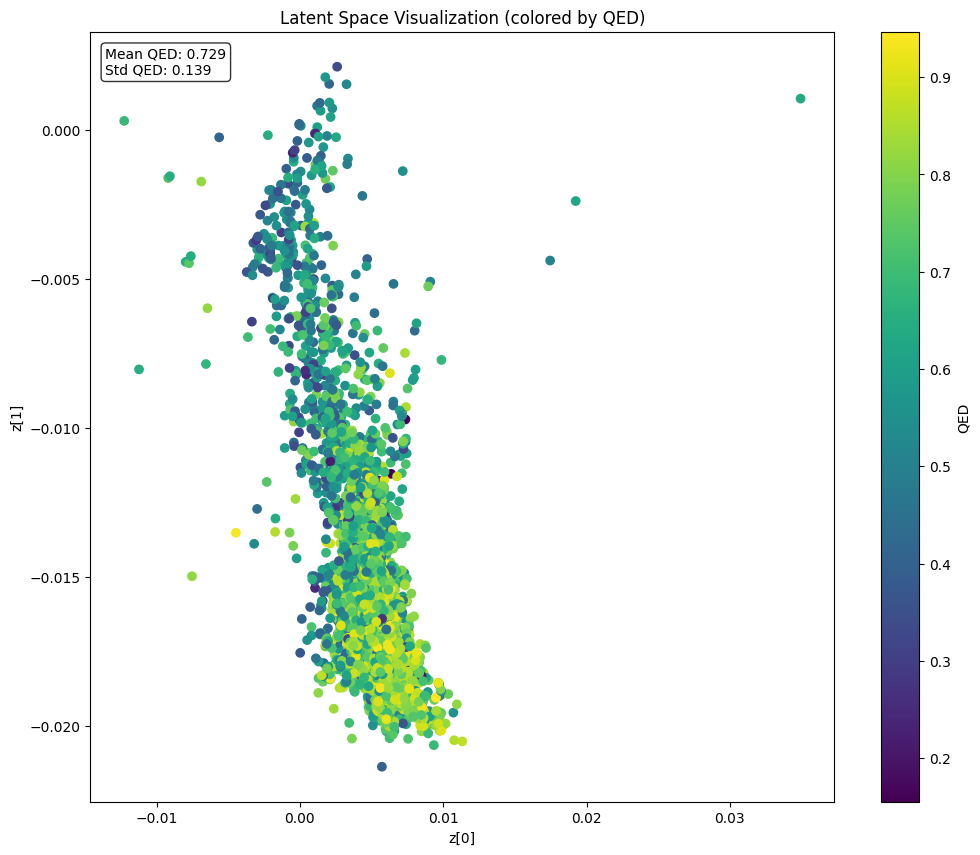


잠재 공간 통계:
Z[0] 범위: [-0.012, 0.035]
Z[1] 범위: [-0.021, 0.002]
Z[0] 평균/표준편차: 0.005 / 0.002
Z[1] 평균/표준편차: -0.016 / 0.003


In [32]:

def plot_latent(model, data, labels, device='cuda'):
    """잠재 공간 시각화"""
    model.eval()  # 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        # 데이터를 텐서로 변환
        adjacency_tensor = torch.FloatTensor(data[0]).to(device)
        feature_tensor = torch.FloatTensor(data[1]).to(device)

        # 배치 크기 설정
        batch_size = 100
        z_means = []

        # 메모리 효율을 위해 배치 단위로 처리
        for i in range(0, len(adjacency_tensor), batch_size):
            batch_adj = adjacency_tensor[i:i+batch_size]
            batch_feat = feature_tensor[i:i+batch_size]

            # 인코더를 통해 잠재 벡터 생성
            z_mean, _ = model.encoder(batch_adj, batch_feat)
            z_means.append(z_mean.cpu().numpy())

    # 결과 합치기
    z_mean = np.concatenate(z_means, axis=0)

    # 시각화
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter, label='QED')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Visualization (colored by QED)")

    # 통계 정보 추가
    plt.text(0.02, 0.98,
             f'Mean QED: {np.mean(labels):.3f}\n'
             f'Std QED: {np.std(labels):.3f}',
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

    # 잠재 공간의 통계 출력
    print("\n잠재 공간 통계:")
    print(f"Z[0] 범위: [{z_mean[:, 0].min():.3f}, {z_mean[:, 0].max():.3f}]")
    print(f"Z[1] 범위: [{z_mean[:, 1].min():.3f}, {z_mean[:, 1].max():.3f}]")
    print(f"Z[0] 평균/표준편차: {z_mean[:, 0].mean():.3f} / {z_mean[:, 0].std():.3f}")
    print(f"Z[1] 평균/표준편차: {z_mean[:, 1].mean():.3f} / {z_mean[:, 1].std():.3f}")

# 사용 예시
def visualize_latent_space(model, dataset, device='cuda'):
    """데이터셋의 잠재 공간 시각화"""
    # 데이터 준비
    adjacency_tensor = dataset.adjacency_tensor[:8000]
    feature_tensor = dataset.feature_tensor[:8000]
    qed_tensor = dataset.qed_tensor[:8000].numpy()

    # 잠재 공간 시각화
    plot_latent(model,
               [adjacency_tensor, feature_tensor],
               qed_tensor,
               device)
visualize_latent_space(model, dataset, device)
